In [2]:
import pickle
import pandas as pd
import numpy as np
import pingouin as pg
import torch
att_path = '/projects/CIBCIGroup/00DataUploading/Liang/fuzzy_fnirs/Friends_fNIRS_Fuzzy/output/output_all_r.pkl'
data_index_path = '/home/xiaowjia/data/Friends_fNIRS/data/temp1/data_index_table_val.csv'
att_method= torch.mean
data_index = pd.read_csv(data_index_path)
output = pickle.load(open(att_path, 'rb'))
centers = output['centers']
converted_centers = output['converted_centers']
correct_att = att_method(output['all_atten'][output['correct_ind']],-2).numpy()
print(correct_att.shape)

correct_att = np.concatenate([correct_att[:, :95, :], correct_att[:, 95:, :]], axis=0)
correct_res = output['res'].iloc[output['correct_ind']]
correct_res = pd.concat([correct_res, correct_res], axis=0)
correct_data_index = data_index.iloc[output['correct_ind']]
correct_data_index = pd.concat([correct_data_index, correct_data_index], axis=0)
correct_att = {i:correct_att[correct_res['label'] == i] for i in correct_res['label'].unique()}



(6832, 190, 10)


In [26]:
# save center to npy
np.save('../output/center_r.npy', centers.detach().numpy())

In [5]:
res_all = [] # ichannel, irule, t, p, df, mean0, mean1, std0, std1, effect_size(up2) BF10
t_values = np.empty((correct_att[0].shape[1], correct_att[0].shape[2]))
for ichannel in range(correct_att[0].shape[1]):
    for irule in range(correct_att[0].shape[2]):
        # run independent t-test
        d1 = correct_att[0][:, ichannel, irule]
        d2 = correct_att[1][:, ichannel, irule]
        stat = pg.ttest(correct_att[0][:, ichannel, irule], correct_att[1][:, ichannel, irule])
        up2 = pg.compute_effsize(d1, d2, eftype='eta-square')
        res_all.append([ichannel, irule, stat['T'].values[0], stat['p-val'].values[0], stat['dof'].values[0], d1.mean(), d2.mean(), d1.std(), d2.std(), up2, stat['BF10'].values[0]])
        t_values[ichannel, irule] = stat['T'].values[0]
res_all = pd.DataFrame(res_all, columns=['ichannel', 'irule', 't', 'p', 'df', 'mean0', 'mean1', 'std0', 'std1', 'effect_size', 'BF10'])
res_all = res_all.sort_values('p', ascending=True)
# print(t_values.shape)
np.save('../output/t_values_r.npy', t_values)

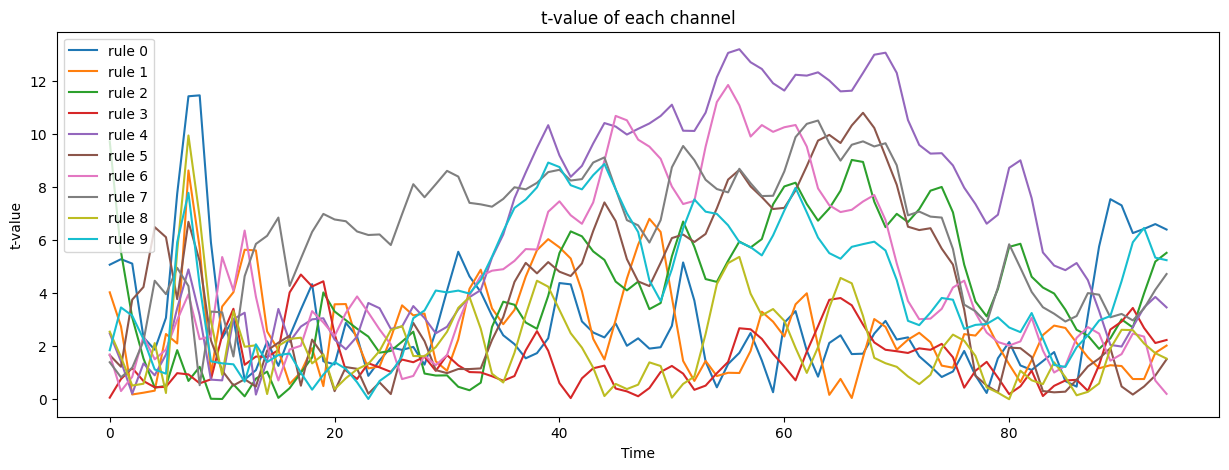

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
# plot line plot, per curve is a rule, t_values is (n_rule, n_time)
for i in range(t_values.shape[1]):
    plt.plot(np.abs(t_values).T[i], label=f'rule {i}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('t-value')
plt.title('t-value of each channel')
plt.show()


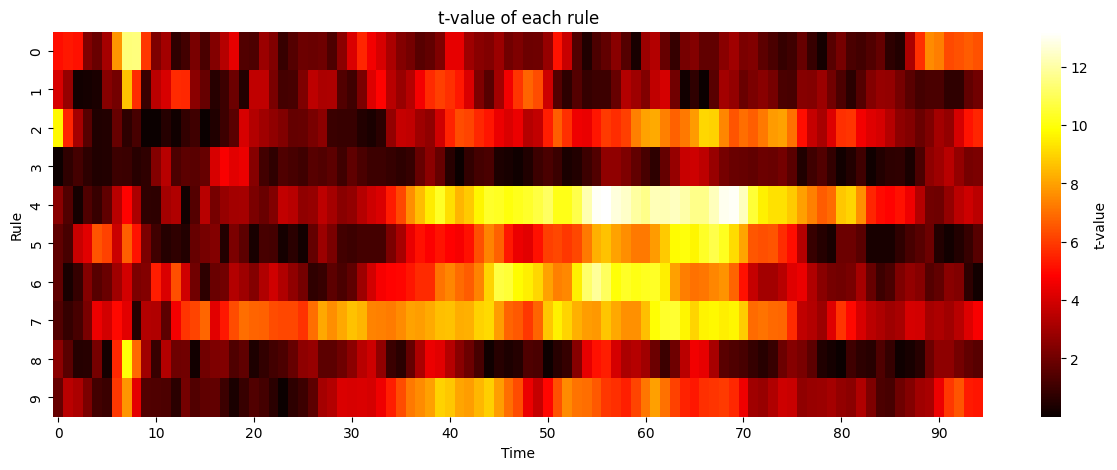

In [22]:
fig = plt.figure(figsize=(15,5))
sns.heatmap(np.abs(t_values).T, cmap='hot', cbar_kws={'label': 't-value'}, xticklabels=10, yticklabels=1)
plt.xlabel('Time')
plt.ylabel('Rule')
plt.title('t-value of each rule')
plt.savefig('../output/t_values_r.svg')